#### *Applied Mathematical Finance 2*

## <ins> *Lab 1: Handling Dividends* </ins>

The deadline is 23:59 on 6th of April, 2025. The solution must be sent up to the deadline on amf2-2025-spring@yandex.ru.


### 1. Cash Dividend Model naive Monte-Carlo (45 points)

Consider the Cash Dividend Model where the stock price dynamics in-between ex-dividend dates $0 < \tau_1 < \cdots < \tau_n < T$ under the risk-neutral measure $\mathbb{Q}$ is given by 


$$dS_t/S_t = rdt + \sigma dW^{\mathbb{Q}}_t, \quad t \in [\tau_{i-1}, \tau_i),$$
$$S_{\tau_{i}-} - S_{\tau_{i}} = d_i.$$

Assume that the initial spot price is $S_0 = 100 \$$, the risk-free interest rate $r=15\%$ and the volatility $\sigma = 25\%$. Also, assume that the stock pays $5\$$ cash dividends in the middle of each year (for the sake of simplicity, assume that there is no dividends payment lag). 

1. **(10 points)** Compute a forward curve $(F_{0, t})_{t \in [0, T]}$. Your answer should contatin a plot of a forward curve. Assume that $T = 5$ years. 

In [115]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import Callable, Any, Union
import warnings
warnings.filterwarnings('ignore')

import py_vollib as iv
import py_vollib.black.implied_volatility as iv
import py_vollib_vectorized


In [116]:
dates = np.linspace(0.5, 4.5, 5)
risk_free_rates = np.full(np.shape(dates), 0.15)
repo_rates = np.zeros(np.shape(dates))

In [117]:
def discount_factors_on_pillar_dates(dates: np.ndarray, rates: np.ndarray):
    """
    Returns discount factors for pillar dates. 

    Args: 
        dates: dates at which the discount factors are computed. 
        rates: zero-rates from which the discount factors are transformed. 
    """
    return np.exp(- dates * rates) # Assume continous compounding convention. 

In [118]:
T = 5

risk_free_dfs = discount_factors_on_pillar_dates(dates=dates, rates=risk_free_rates)
repo_dfs = discount_factors_on_pillar_dates(dates=dates, rates=repo_rates)

In [119]:
def build_dicount_factor_curve_based_on_pillar_discount_factors(
    dates: np.ndarray,
    discount_factors: np.ndarray
):
    """
    Build discount factor curve based on pillar discount factors. Linear interpolation in \log(DF(t, T)) wrt T assumed. 

    Args: 
        dates: dates at which the discount factors are given. 
        discount: the discount factors to interpolate. 
    """
    log_discount_factors = np.log(discount_factors)
    intepolator = interp1d(x=dates, y=log_discount_factors, kind="linear", fill_value="extrapolate")
    return lambda x: np.exp(intepolator(x))


In [120]:
risk_free_dfs_curve = build_dicount_factor_curve_based_on_pillar_discount_factors(
    dates=dates, 
    discount_factors=risk_free_dfs
)
repo_dfs_curve = build_dicount_factor_curve_based_on_pillar_discount_factors(
    dates=dates, 
    discount_factors=repo_dfs
)

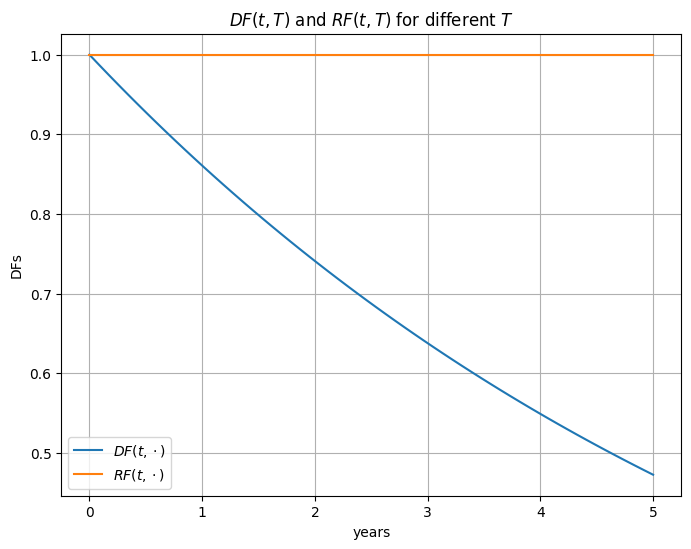

In [121]:
time_greed = np.linspace(0, T, int(T * 12))

plt.figure(figsize=(8, 6))
plt.title("$DF(t, T)$ and $RF(t, T)$ for different $T$".format(5, 0))
plt.plot(time_greed, risk_free_dfs_curve(time_greed), label="$DF(t, \cdot)$")
plt.plot(time_greed, repo_dfs_curve(time_greed), label="$RF(t, \cdot)$")
plt.xlabel("years")
plt.ylabel("DFs")
plt.grid()
plt.legend()
plt.show()

In [122]:
S_ref = 100
t_ex = np.linspace(0.5, 4.5, 5)
t_p = np.linspace(0.5, 4.5, 5)
alphas = np.full(np.shape(dates), 5)
betas = np.zeros(np.shape(dates))

In [123]:
def get_discounted_dividends(alphas: np.ndarray, betas: np.ndarray, t_ex: np.ndarray, t_p: np.ndarray, 
                             risk_free_dfs_curve: Callable[[float], float], repo_dfs_curve: Callable[[float], float]):
    """
    Calculates the discounted dividends $\bar alpha_t$, $\bar \beta_t$, i.e. effectively discounts 
    the dividends from payment dates to ex-dividend dates. 

    Args:
        alphas: fixed dividends. 
        betas: proportional dividends. 
        t_ex: ex-dividend dates. 
        t_p: payment dates.
        risk_free_dfs_curve: the risk-free rate discount factor curve.
        repo_dfs_curve: the repo-rate discount factor curve. 
    """
    alphas_disc = np.zeros_like(alphas)
    betas_disc = np.zeros_like(betas)
    
    for i, (t_ex_i, t_p_i) in enumerate(zip(t_ex, t_p)):
        carry_rate = (risk_free_dfs_curve(t_p_i) /  risk_free_dfs_curve(t_ex_i)) / (repo_dfs_curve(t_p_i) /  repo_dfs_curve(t_ex_i))
        alphas_disc[i] = alphas[i] * carry_rate
        betas_disc[i] = betas[i] *  carry_rate

    return alphas_disc, betas_disc

In [124]:
alphas_disc, betas_disc = get_discounted_dividends(
    alphas=alphas, betas=betas, t_ex=t_ex, t_p=t_p, 
    risk_free_dfs_curve=risk_free_dfs_curve, 
    repo_dfs_curve=repo_dfs_curve
)

In [125]:
def effective_carry_rate(t_ex: np.ndarray, betas_disc: np.ndarray, 
                         risk_free_dfs_curve: Callable[[float], float], 
                         repo_dfs_curve: Callable[[float], float]): 
    """
    Calculates the effective carry rate R(t, T). 

    Args: 
        t_ex: ex-dividend dates. 
        betas_disc: discounted from t_p to t_ex proportional dividends.
        risk_free_dfs_curve: the risk-free rate discount factor curve.
        repo_dfs_curve: the repo-rate discount factor curve.
    """
    betas_disc_complement = 1 - betas_disc
    return lambda t, T : (repo_dfs_curve(T) / repo_dfs_curve(t)) / (risk_free_dfs_curve(T) / risk_free_dfs_curve(t)) * np.prod(betas_disc_complement[(t < t_ex) &  (t_ex <= T)])

In [126]:
R = effective_carry_rate(t_ex=t_ex, betas_disc=betas_disc, 
                         risk_free_dfs_curve=risk_free_dfs_curve, 
                         repo_dfs_curve=repo_dfs_curve)

In [127]:
def cash_divs_present_value(t_ex: np.ndarray, alphas_disc: np.ndarray, R: Callable[[float, float], float]): 
    """
    Calculates the present value of cash dividends Div(t, T). 

    Args: 
        t_ex: ex-dividend dates. 
        alphas_disc: discounted from t_p to t_ex fixed dividends.
        R: carry rate. 
    """
    return lambda t, T: np.sum((alphas_disc / R(t, t_ex))[(t < t_ex) & (t_ex <= T)])

In [128]:
Div = cash_divs_present_value(t_ex=t_ex, alphas_disc=alphas_disc, R=R)

In [129]:
def equity_forward(S_ref: float, Div: Callable[[float, float], float], R: Callable[[float, float], float]):
    """
    Calculates the equity forward F(t, T).  

    Args: 
        S_ref: spot value. 
        Div: present value of cash dividends. 
        R: carry rate. 
    """
    return np.vectorize(lambda t, T: R(t, T) * (S_ref - Div(t, T)))


In [130]:
equity_forward_curve = equity_forward(S_ref=S_ref, Div=Div, R=R)

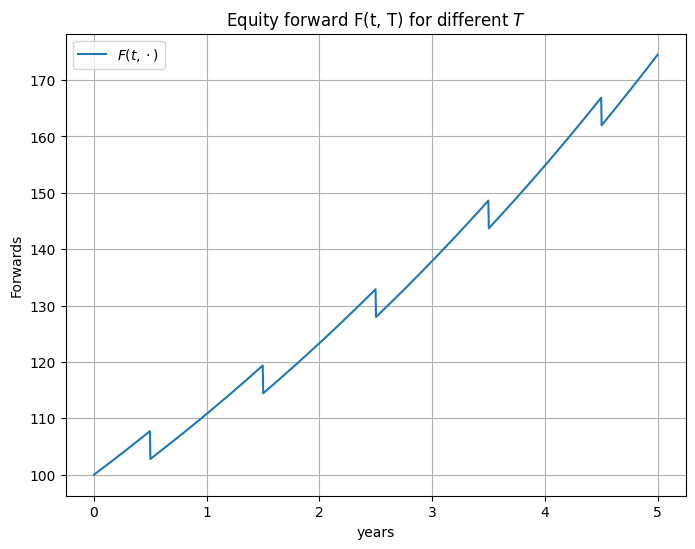

In [131]:
T = 5; t = 0
time_greed = np.linspace(t, T, int(T * 12 * 21))

plt.figure(figsize=(8, 6))
plt.title("Equity forward F(t, T) for different $T$")
plt.plot(time_greed, equity_forward_curve(t, time_greed), label="$F(t, \cdot)$")
plt.xlabel("years")
plt.ylabel("Forwards")
plt.grid()
plt.legend()
plt.show()

In [132]:
equity_forward_curve(0, 5)

array(174.50155113)

2. **(15 points)** Using the Monte-Carlo method, obtain the prices of vanilla options (in terms of Black implied volatilities) with maturity $T=5$ years. Use the strikes $K$ ranging from $40$ to $160$ with step $5$. Your answer should contain an implied volatilities curve plot.

In [133]:
def simulated_geometric_brownian_motion_with_discrete_dividend(
    S_ref: float,
    sigma: float,
    risk_free_rate: float,
    T: float,
    cash_divs_value: float,
    cash_divs_dates: np.ndarray,
    num_steps: int,
    num_simulation: np.ndarray
):
    t_prev = 0
    trajectory = np.full((num_simulation, ), S_ref)

    for t_i in cash_divs_dates:
        dt = t_i - t_prev
        
        dW = np.random.normal(0, 1, num_simulation)
        trajectory = trajectory * np.exp((risk_free_rate[0] - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*dW)
        
        trajectory = trajectory - cash_divs_value
        
        t_prev = t_i

    dt = T - t_prev
    dW = np.random.normal(0, 1, num_simulation)
    trajectory = trajectory * np.exp((risk_free_rate[0] - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*dW)
    return trajectory

In [134]:
sigma = 0.25
# num_steps = T*365
num_steps = 100
num_simulation = 1_000_000
alpha = 5

result = simulated_geometric_brownian_motion_with_discrete_dividend(
    S_ref=S_ref,
    sigma=sigma,
    risk_free_rate=risk_free_rates,
    T=T,
    cash_divs_value=alpha,
    cash_divs_dates=t_ex,
    num_steps=num_steps,
    num_simulation=num_simulation
)

In [135]:
def get_call_option_price(
    simulation: np.ndarray,
    strike: float,
    df: float
):
    return df*np.maximum(simulation - strike, 0).mean()

In [136]:
def get_implied_volatility(
    discounted_prices: float, T: float, K: float,
    forward: float, type_opt: str, r: float
):
    return np.squeeze(
        iv.implied_volatility(
            discounted_prices, forward, K, r, T, type_opt
        )
    )

In [137]:
strikes = np.arange(40, 165, 5)
call_option_price = []


for strike in strikes:
    call_option_price.append(
        get_call_option_price(
            simulation=result,
            strike=strike,
            df=risk_free_dfs_curve(T)
        )
    )

implied_vols = get_implied_volatility(
    discounted_prices=call_option_price, T=T, K=strikes,
    forward=equity_forward_curve(0, T),type_opt="c",
    r=risk_free_rates[0]
)

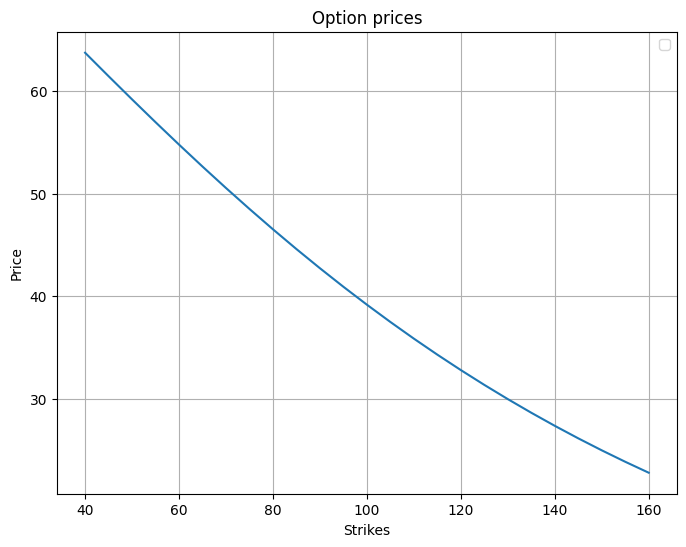

In [138]:
plt.figure(figsize=(8, 6))
plt.title("Option prices")
plt.plot(strikes, call_option_price)
plt.xlabel("Strikes")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()

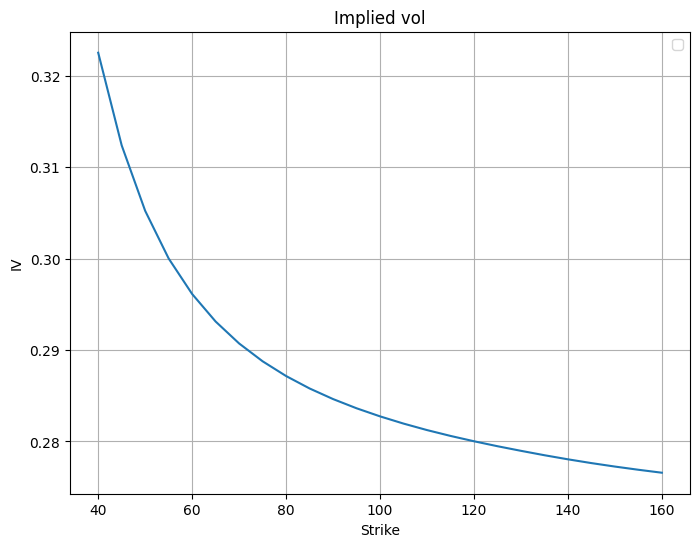

In [139]:
plt.figure(figsize=(8, 6))
plt.title("Implied vol")
plt.plot(strikes, implied_vols)
plt.xlabel("Strike")
plt.ylabel("IV")
plt.grid()
plt.legend()
plt.show()

3. **(10 points)** Show that your Monte-Carlo algorithm converges in terms of decreasing empirical (relative) error when the number of simulations increases. Your answer should contain a plot of error as a function of number of simulations. 


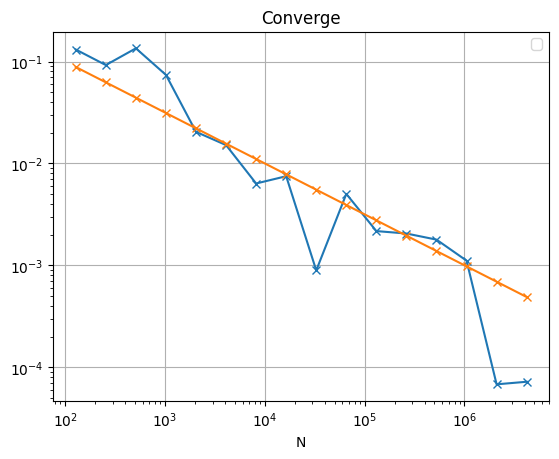

In [140]:
num_simulations = 2**(np.linspace(6, 22, 17, dtype=int))
num_steps = 100
strike = 60

abs_error = np.zeros(np.shape(num_simulations))
for index, num_simulation in enumerate(num_simulations):
    abs_error[index] = simulated_geometric_brownian_motion_with_discrete_dividend(
        S_ref=S_ref,
        sigma=sigma,
        risk_free_rate=risk_free_rates,
        T=T,
        cash_divs_value=alpha,
        cash_divs_dates=t_ex,
        num_steps=num_steps,
        num_simulation=num_simulation
    ).mean()

plt.loglog(
    num_simulations[1:],
    np.abs(np.diff(abs_error)/abs_error[:-1]),
    marker="x"
)
plt.loglog(
    num_simulations[1:],
    1/np.sqrt(num_simulations[1:]),
    marker="x"
)

plt.title('Converge')
plt.xlabel("N")
plt.legend()
plt.grid()
plt.show()

4. **(10 points)** As a sanity check of your simulations algorithm, show that the empirically averaged stock sprice $S_T$ converges to a forward price $F_{0, T}$ when number of monte carlo simulations increases. 

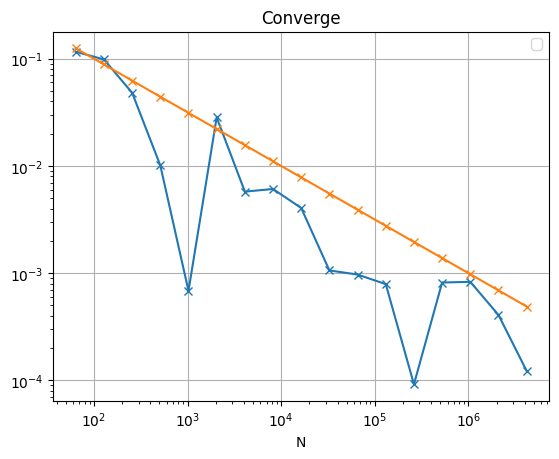

In [141]:
num_simulations = 2**(np.linspace(6, 22, 17, dtype=int))
num_steps = 100
strike = 60

abs_error = np.zeros(np.shape(num_simulations))
for index, num_simulation in enumerate(num_simulations):
    abs_error[index] = simulated_geometric_brownian_motion_with_discrete_dividend(
        S_ref=S_ref,
        sigma=sigma,
        risk_free_rate=risk_free_rates,
        T=T,
        cash_divs_value=alpha,
        cash_divs_dates=t_ex,
        num_steps=num_steps,
        num_simulation=num_simulation
    ).mean()

plt.loglog(
    num_simulations,
    np.abs(abs_error - equity_forward_curve(0, T)) / abs_error,
    marker="x"
)
plt.loglog(
    num_simulations,
    1/np.sqrt(num_simulations),
    marker="x"
)

plt.title('Converge')
plt.xlabel("N")
plt.legend()
plt.grid()
plt.show()

### 2. Cash Dividend Model approximations (55 points)

Using option prices obtained in the problem above, compute implied volatilities corresponding to each of the following affine approximations of the Cash Dividend Model.  Each of your answers should contain an implied volatilities curve plot.

For each model, make your conclusion about the quality of the approximation. What happens with the implied volatility when the valuation date passes the ex-dividend date? When the option's expiry date passes the ex-div date? 

In [164]:
def implied_vol(
    option_prices,
    S_ref: float,
    sigma: float,
    risk_free_rate: float,
    T: float,
    cash_divs_value: float,
    cash_divs_dates: np.ndarray,
    vol_type: str = "Black",
    option_type: str = "c",
    strikes: np.ndarray = np.linspace(40,160,25)
) -> np.ndarray:
               
    match vol_type:
        case "Spot":
            futureCash = np.sum(np.exp(-cash_divs_dates * risk_free_rate) * np.full(np.shape(cash_divs_dates), cash_divs_value))
            h_T = -futureCash * np.exp(risk_free_rate * T)
            g_T = S_ref * np.exp(risk_free_rate * T)
            return np.squeeze(
                iv.implied_volatility(
                    option_prices,
                    g_T, 
                    strikes - h_T, 
                    risk_free_rate, 
                    T, 
                    'c'
                )
            )
        case "Black":
            futureCash = np.sum(np.exp(-cash_divs_dates * risk_free_rate) * np.full(np.shape(cash_divs_dates), cash_divs_value))
            f_T = (S_ref - futureCash) * np.exp(risk_free_rate * T)

            return np.squeeze(
                iv.implied_volatility(
                    option_prices, 
                    f_T, 
                    strikes, 
                    risk_free_rate,
                    T, 
                    'c'
                )
            )
        case "Bos-Vandermark": 
            futureCash = np.sum(np.exp(-cash_divs_dates * risk_free_rate) * np.full(np.shape(cash_divs_dates), cash_divs_value))

            nearCash = np.sum(np.exp(-cash_divs_dates * risk_free_rate) * np.full(np.shape(cash_divs_dates), cash_divs_value) * (T - cash_divs_dates) / T)

            h_T = -(futureCash - nearCash) * np.exp(risk_free_rate * T)
            g_T = (S_ref - nearCash) * np.exp(risk_free_rate * T)

            return np.squeeze(
                iv.implied_volatility(
                    option_prices, 
                    g_T, 
                    strikes - h_T, 
                    risk_free_rate, 
                    T, 
                    'c'
                )
            )


In [165]:
spot = implied_vol(
    call_option_price,
    S_ref=100.0,
    sigma=sigma,
    risk_free_rate=risk_free_rates[0],
    T=T, cash_divs_value=5, cash_divs_dates=dates,
    vol_type="Spot"
)
black = implied_vol(
    call_option_price,
    S_ref=100.0,
    sigma=sigma,
    risk_free_rate=risk_free_rates[0],
    T=T, cash_divs_value=5, cash_divs_dates=dates,
    vol_type="Black"
)
bos_vandermark = implied_vol(
    call_option_price,
    S_ref=100.0,
    sigma=sigma,
    risk_free_rate=risk_free_rates[0],
    T=T, cash_divs_value=5, cash_divs_dates=dates,
    vol_type="Bos-Vandermark"
)

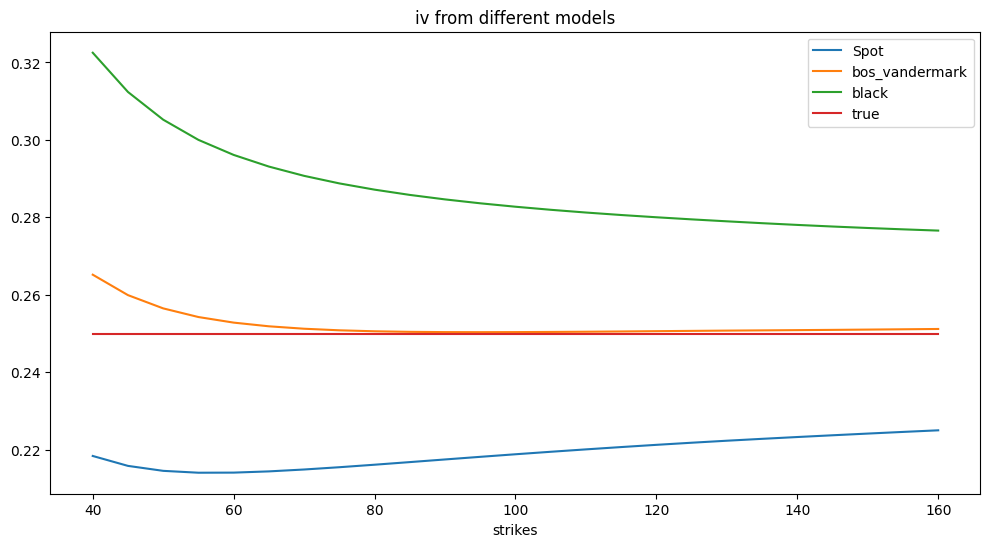

In [173]:
plt.figure(figsize=(12,6))

plt.plot(strikes, spot, label="Spot")
plt.plot(strikes, bos_vandermark, label="bos_vandermark")
plt.plot(strikes, black, label="black")
plt.plot(strikes, np.ones_like(strikes)*sigma, label="true")
plt.title("iv from different models")
plt.xlabel("strikes")
plt.legend()
plt.show()

Видно на графике что, Bos-Vandermark лучше всего приближает для piece-wise const log-normal vol, но цены лучше приблизит Black. После даты экспирации будем наблюдать как с долгой скоростью модели приближают sigma. Аналогично с прохождением ex-date.